In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

/var/folders/0p/nmvxp1px72q3ml7745bcbn9m0000gn/T/ipykernel_32191/2969453729.py:2: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_handlebar_acc = pd.read_csv('../data/combined/handlebar_acc.csv')


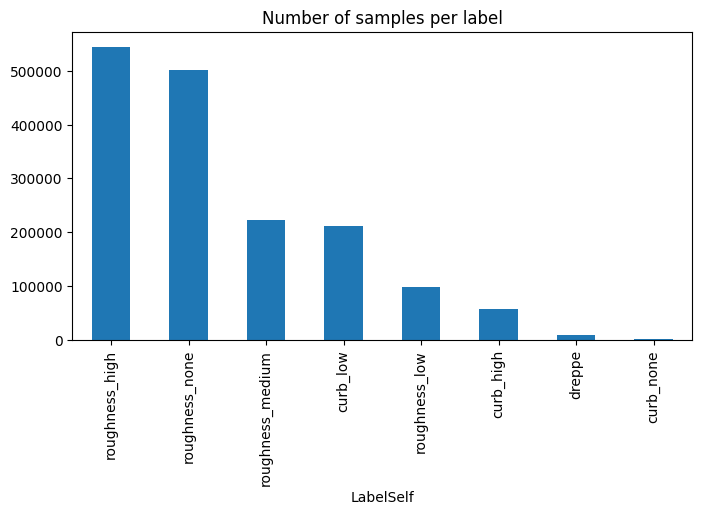

num samples after resampling: 4504


,Acc-X,Acc-Y,Acc-Z,LabelSelf,LabelOther
NTP,,,,,
2024-05-28 15:21:46,-0.118092,1.650410,10.432173,roughness_medium,roughness_medium
2024-05-28 15:21:47,0.138077,2.208235,9.764220,roughness_medium,roughness_medium
2024-05-28 15:21:48,0.109348,2.315970,9.958142,roughness_medium,roughness_medium
2024-05-28 15:21:49,-0.276102,3.161086,8.720393,roughness_medium,roughness_medium
2024-05-28 15:21:50,1.315974,4.461082,6.965518,roughness_medium,roughness_medium


In [71]:
# read raw data and set NTP as datetime index
df_handlebar_acc = pd.read_csv('../data/combined/handlebar_acc.csv')
df_handlebar_acc['NTP'] = pd.to_datetime(df_handlebar_acc['NTP'])
df_handlebar_acc.set_index('NTP', inplace=True)

# forward fill the labels
df_handlebar_acc[['LabelSelf', 'LabelOther']] = df_handlebar_acc[['LabelSelf', 'LabelOther']].ffill()

# bar plot of the number of samples per label
df_handlebar_acc['LabelSelf'].value_counts().plot(kind='bar', title='Number of samples per label', figsize=(8, 4))
plt.show()

# resample to 1 second
df_handlebar_acc = df_handlebar_acc.resample('1s').first()

print(f'num samples after resampling: {len(df_handlebar_acc)}')
df_handlebar_acc.head()

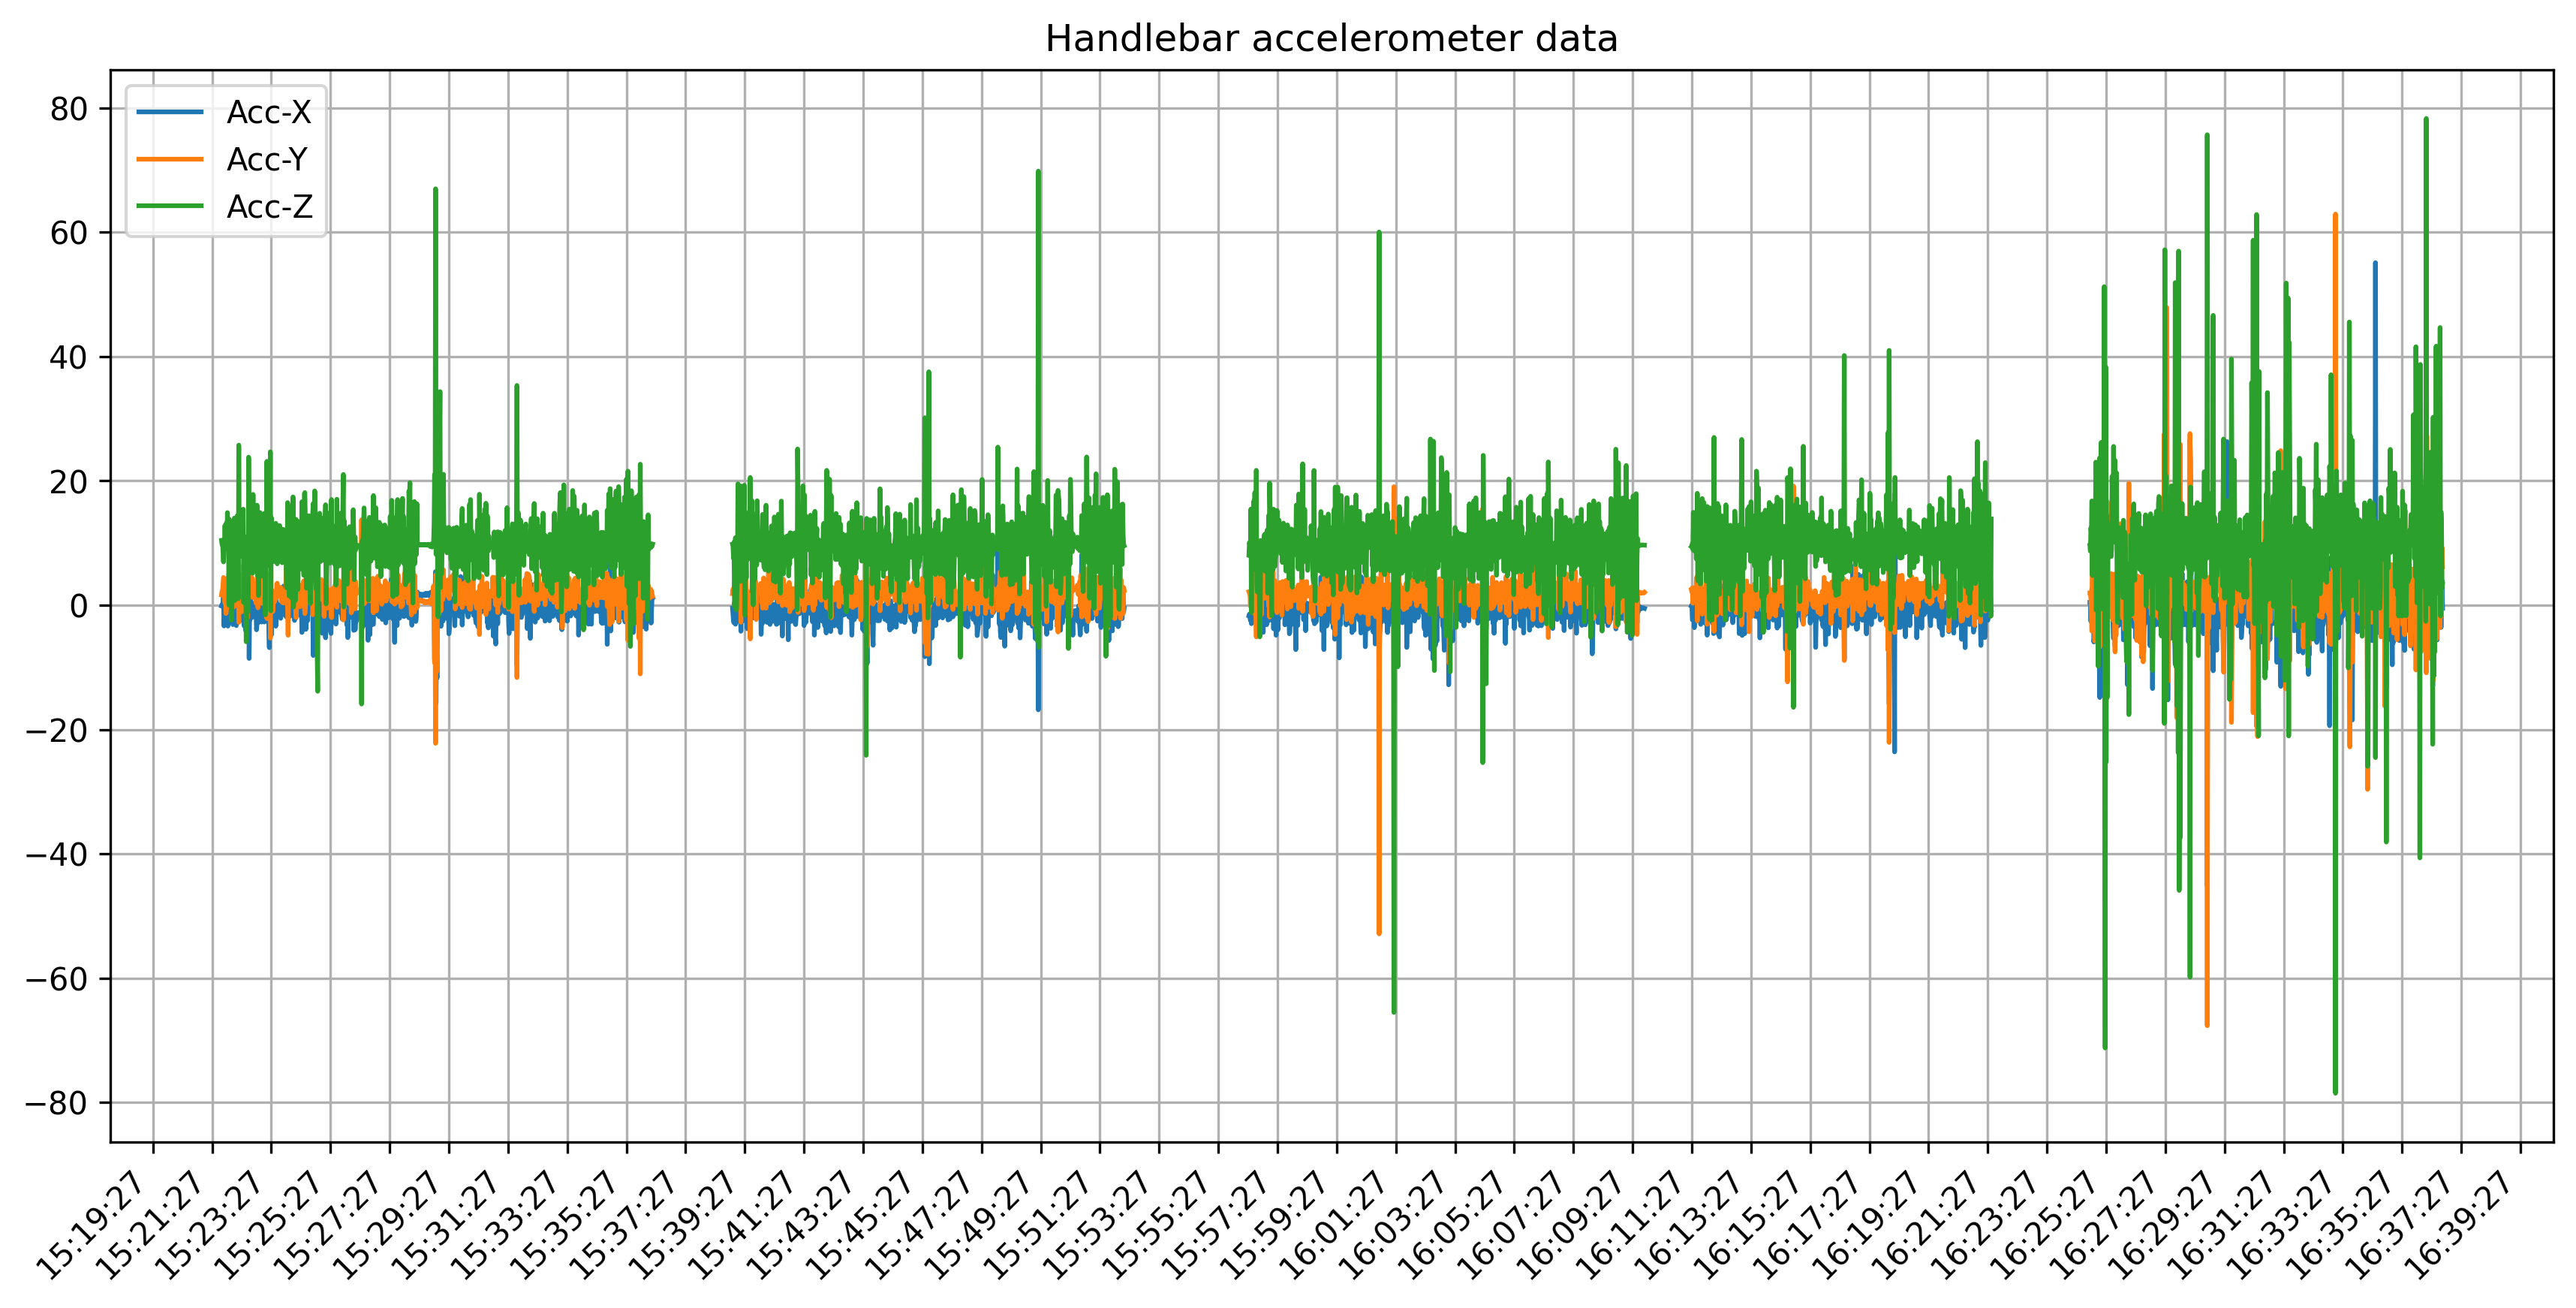

In [61]:
plt.figure(figsize=(14, 7), dpi=300)
plt.title('Handlebar accelerometer data')
plt.plot(df_handlebar_acc.index, df_handlebar_acc['Acc-X'], label='Acc-X')
plt.plot(df_handlebar_acc.index, df_handlebar_acc['Acc-Y'], label='Acc-Y')
plt.plot(df_handlebar_acc.index, df_handlebar_acc['Acc-Z'], label='Acc-Z')
plt.legend()
plt.grid()
plt.gcf().autofmt_xdate()
plt.xticks(rotation=45)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.SecondLocator(interval=120))
plt.show()

In [73]:
df_handlebar_acc[['Acc-X', 'Acc-Y', 'Acc-Z']].describe()

,Acc-X,Acc-Y,Acc-Z
count,3798.000000,3798.000000,3798.000000
mean,-0.672905,2.066843,9.490913
std,2.977493,3.821340,7.297360
min,-45.203760,-67.658750,-78.532540
25%,-1.860995,0.683793,6.762020
50%,-0.642399,2.058604,9.596633
75%,0.597145,3.414262,12.266652
max,55.116160,62.936943,78.314445


<Axes: ylabel='Frequency'>

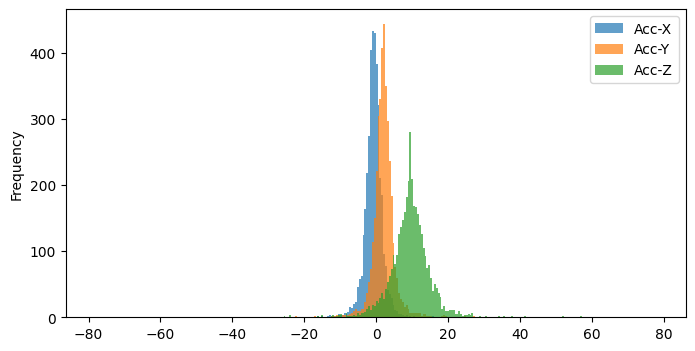

In [91]:
# distribution of the accelerometer data
df_handlebar_acc[['Acc-X', 'Acc-Y', 'Acc-Z']].plot(kind='hist', bins=300, alpha=0.7, figsize=(8, 4))

<Axes: xlabel='NTP'>

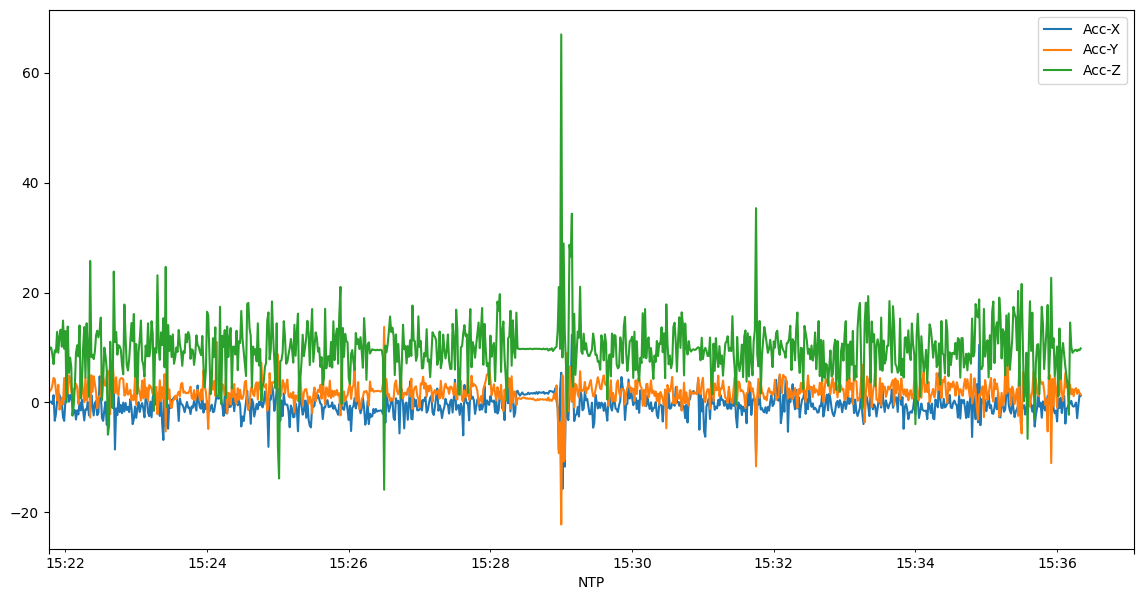

In [107]:
df_handlebar_acc[['Acc-X', 'Acc-Y', 'Acc-Z']][:920].plot(kind='line', figsize=(14, 7))

## Plot sliding windows with labels

In [3]:
import sys
sys.path.append('..')
import pandas as pd
import matplotlib.pyplot as plt

from dataset.cycling_dataset import get_dataset

In [2]:
train_dataset = get_dataset(
    file_path_acc='/Users/Aleyna/downloads/preprocessed/handlebar_acc_train.h5',
    file_path_gyro='/Users/Aleyna/downloads/preprocessed/handlebar_gyro_train.h5',
)

test_dataset = get_dataset(
    file_path_acc='/Users/Aleyna/downloads/preprocessed/handlebar_acc_test.h5',
    file_path_gyro='/Users/Aleyna/downloads/preprocessed/handlebar_gyro_test.h5',
)

In [52]:
windows_train, labels_train = train_dataset
windows_test, labels_test = test_dataset

labels_train = labels_train.astype(str)
labels_test = labels_test.astype(str)

# pd Series
windows_train.shape
np.unique(labels_train)

array(['curb_high', 'curb_low', 'roughness_high', 'roughness_low',
       'roughness_medium'], dtype='<U16')

In [140]:
dfs = []
for i in range(windows_train.shape[0]):
    df = pd.DataFrame(windows_train[i], columns=[f'feature_{j}' for j in range(windows_train.shape[2])])
    df['window'] = i
    dfs.append(df)

# Concatenate the list of DataFrames into a single DataFrame and add labels
result_df = pd.concat(dfs, axis=0).reset_index(drop=True)

# Set a multi-level index (window number and timestep)
result_df.set_index(['window', result_df.groupby('window').cumcount()], inplace=True)
result_df.index.names = ['window', 'timestep']

result_df.columns = ['Acc-X', 'Acc-Y', 'Acc-Z', 'Gyro-X', 'Gyro-Y', 'Gyro-Z']
labels_train = pd.Series(labels_train, name='label')

['curb_high' 'curb_low' 'roughness_high' 'roughness_low']


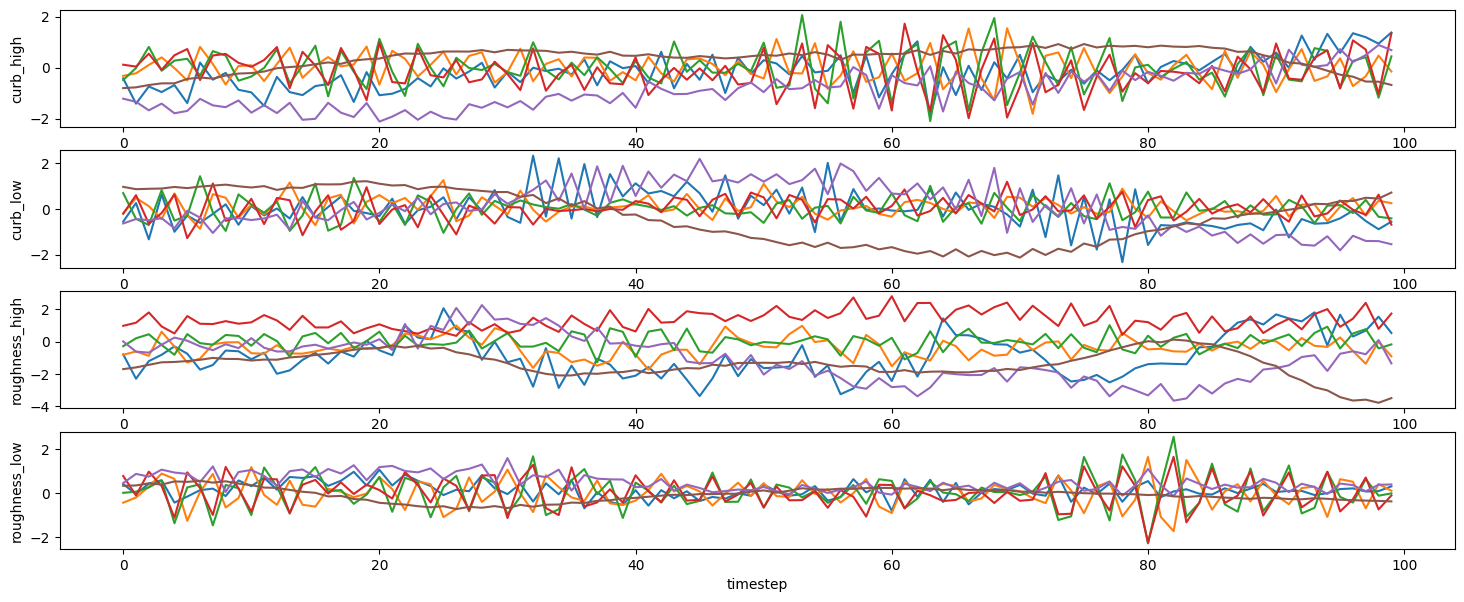

In [168]:
labels = np.unique(labels_train)
print(labels)
fig, axs = plt.subplots(len(labels), 1, figsize=(18, 7))

for idx, label in enumerate(labels):
    # Get the indices of windows with 'roughness_high'
    label_indices = labels_train[labels_train == label].index

    # Access the windows with 'roughness_high' label
    windows_roughness_high = result_df.loc[label_indices]

    # Plot a random window
    first_window = windows_roughness_high.loc[label_indices[np.random.randint(0, len(label_indices))]]

    first_window.plot(kind='line', ylabel=label, ax=axs[idx], legend=False)

plt.show()